In [1]:
from src.dl.inference.inferer import Inferer
import src.dl.lightning as lightning
from src.utils.gson_merger import GSONMerger
from src.data import PannukeDataModule, ConsepDataModule

In [2]:
# Initialize the inferer
in_dir = "/home/leos/mnt/storageBig8/work/leos/cin/train_test_set/train/testimg"
gt_dir = None # This is optional. Can be None
exp_name = "panoptic" # name of the experiment (directory)
exp_version = "effnetv2" # name of the experiment version (sub directory inside the experiment dir)
lightning_model = lightning.SegModel.from_experiment(name=exp_name, version=exp_version)

inferer = Inferer(
    lightning_model,
    in_data_dir=in_dir,
    gt_mask_dir=gt_dir,
    patch_size=(256, 256),
    stride_size=80,
    fn_pattern="*",
    model_weights="last",
    apply_weights=True,
    post_proc_method="cellpose",
    loader_batch_size=1,
    loader_num_workers=1,
    model_batch_size=8,
    auto_range=False
) 

In [3]:
inferer.run_inference(
    # save_dir="my_geojson_dir",
    # fformat="geojson",
    # offsets=True
)

Running inference for ['YP14-27904_1_HE_x-11809_y-13745']: 100%|██████████| 11/11 [02:20<00:00, 12.77s/batch, patches=4887/396]
Post-processing: 100%|██████████| 11/11 [01:02<00:00,  5.70s/it]


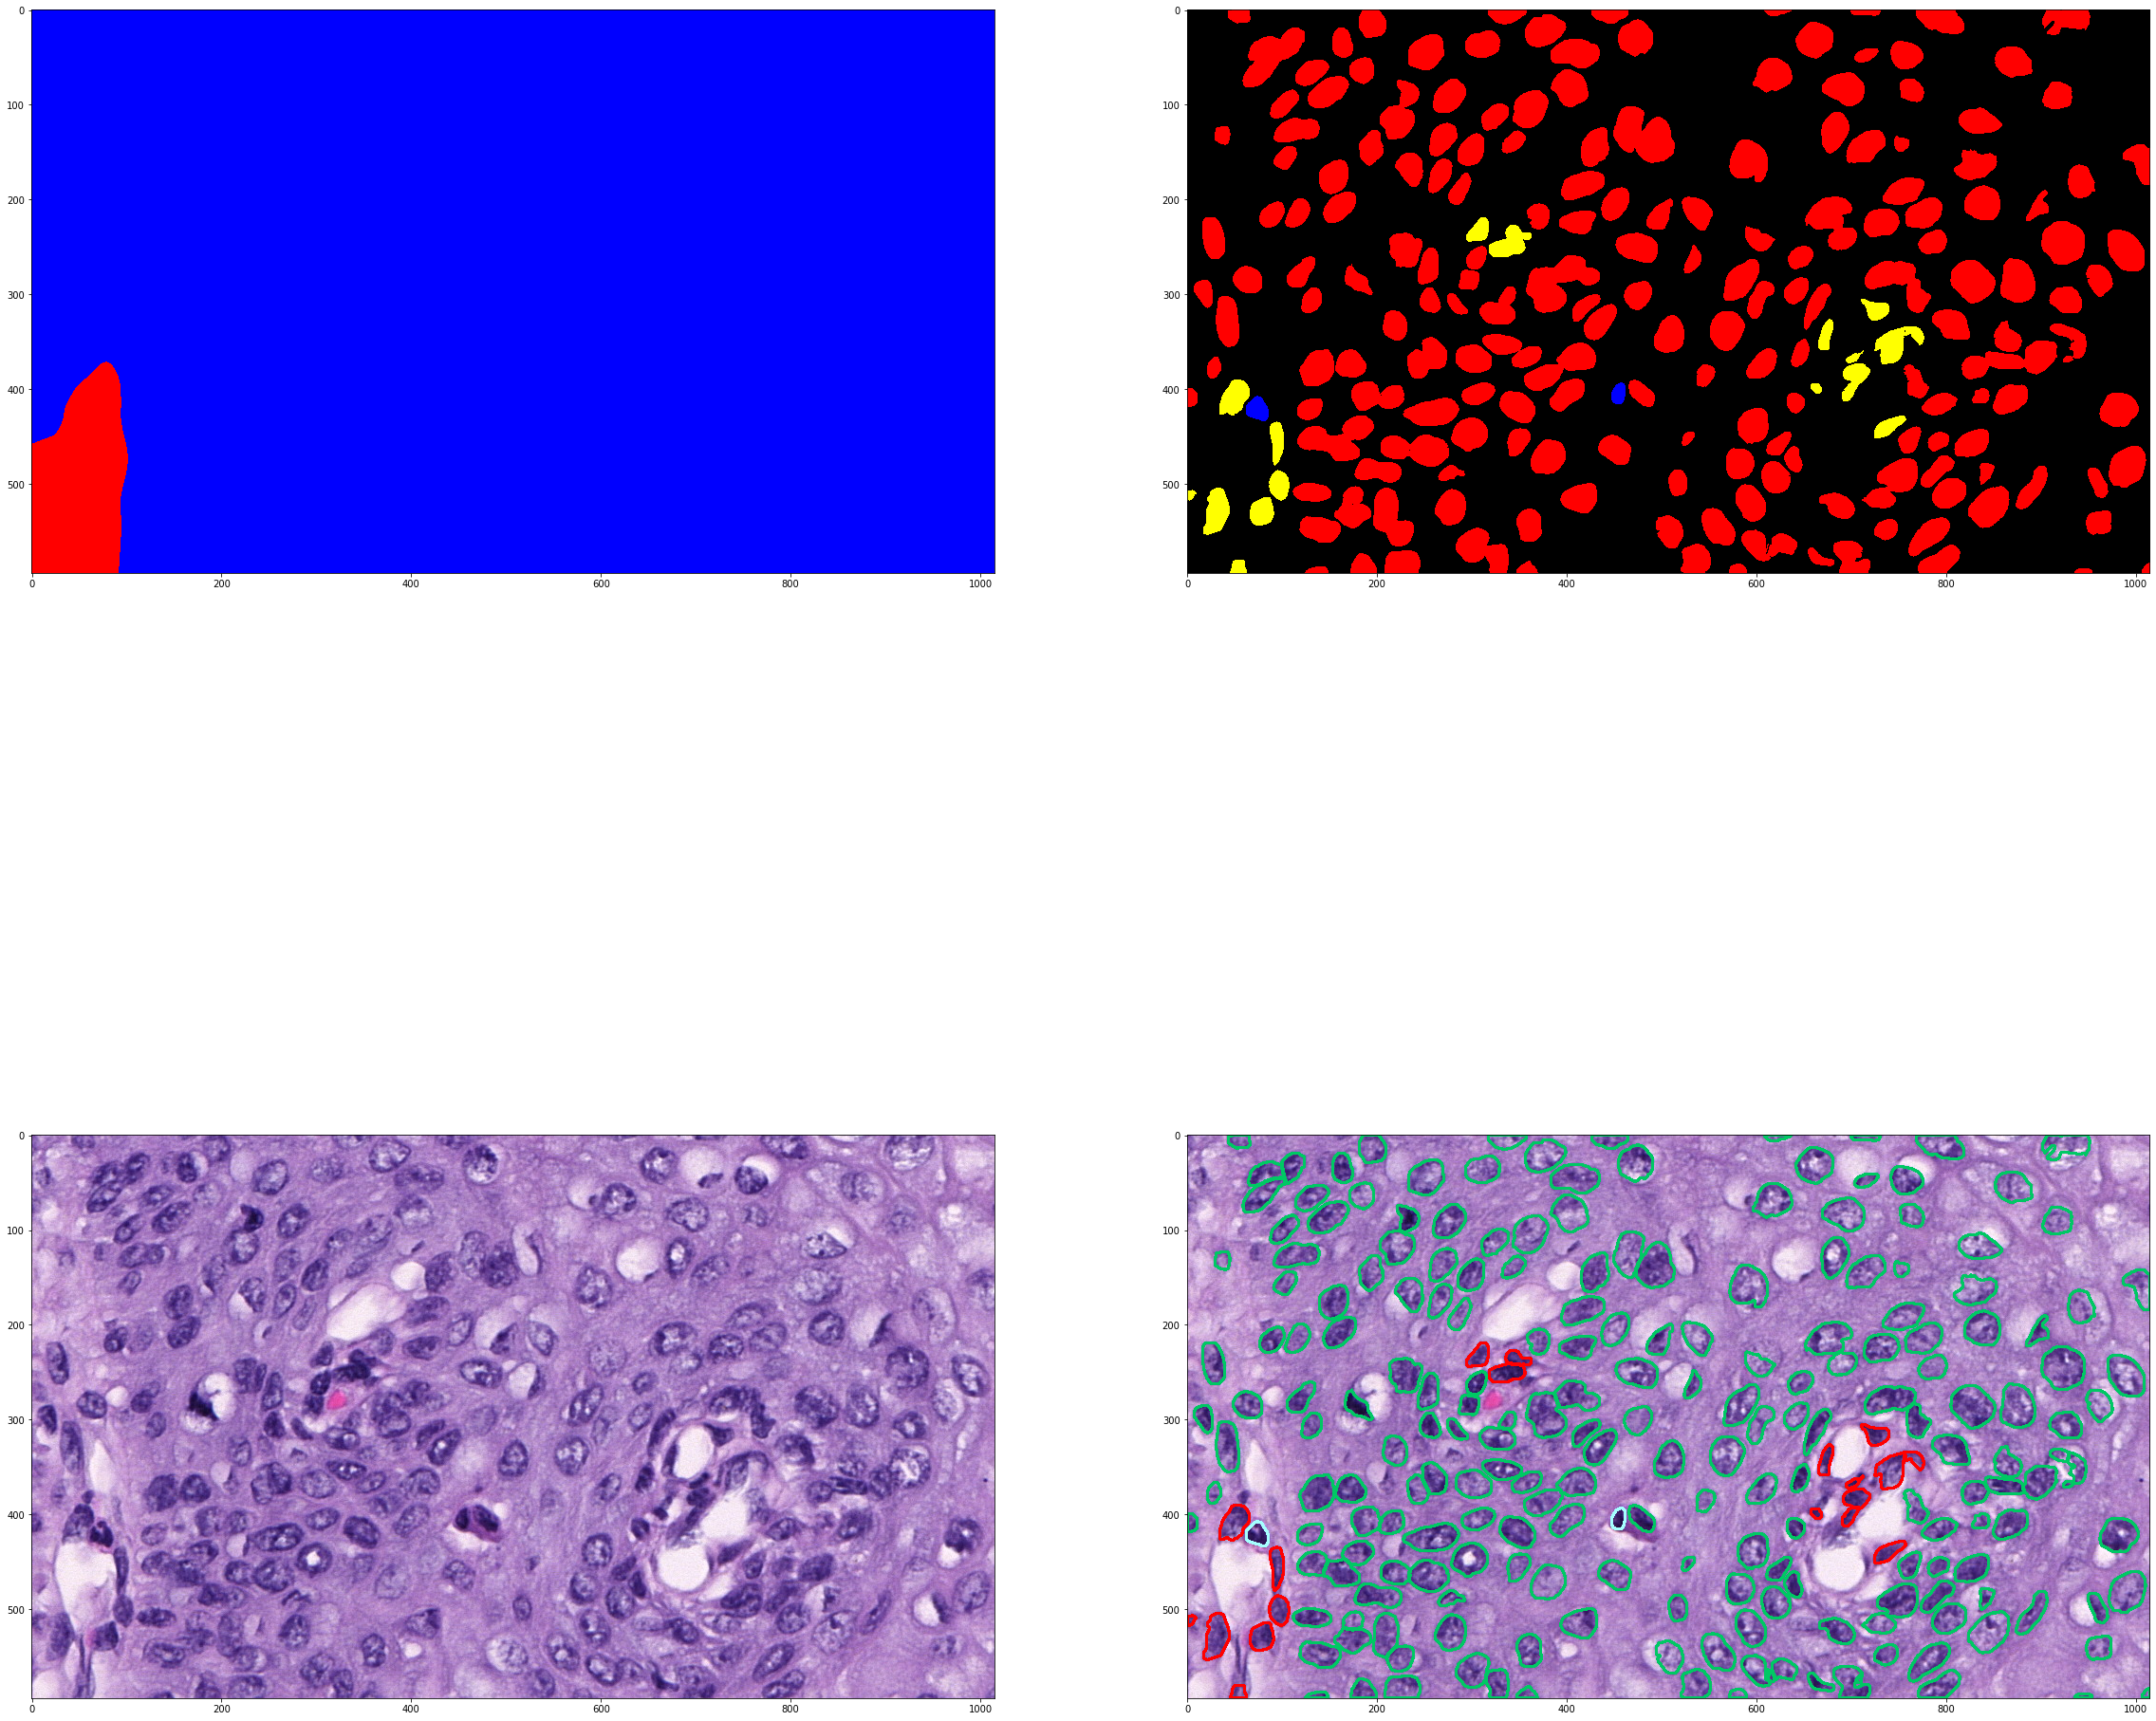

In [78]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from src.utils import FileHandler
from pathlib import Path

from src.utils import draw_thing_contours, draw_stuff_contours, label_sem_map,

area_classes = {
    "background": 0,
    "areastroma": 1,
    "area_cin": 2,
    "areasquam": 3,
    "areagland": 4,
}

cell_classes = {
    "background": 0,
    "neoplastic": 1,
    "inflammatory": 2,
    "connective": 3,
    "dead": 4,
    "glandular_epithel": 5,
    "squamous_epithel": 6
}


ix = 5
keys = list(inferer.soft_insts.keys())
key = keys[ix]
img = FileHandler.read_img([f for f in sorted(Path(inferer.in_data_dir).glob("*")) if key in f.name][0])
areas = draw_stuff_contours(label_sem_map(inferer.sem_maps[key]), img, inferer.sem_maps[key], classes=area_classes, thickness=5, fill_contours=True)
everything = draw_thing_contours(inferer.inst_maps[key], areas, inferer.type_maps[key], classes=cell_classes)

fig, ax = plt.subplots(2, 2, figsize=(40, 40))
ax = ax.flatten()
ax[0].imshow(label2rgb(inferer.sem_maps[key], bg_label=0))
ax[1].imshow(label2rgb(inferer.type_maps[key], bg_label=0))
ax[2].imshow(img)
ax[3].imshow(everything)
# ax[2].imshow(label2rgb(FileHandler.read_mask([f for f in inferer.gt_mask_dir if key in f.name][0], "inst_map"), bg_label=0))
# ax[3].imshow(label2rgb(FileHandler.read_mask([f for f in inferer.gt_mask_dir if key in f.name][0], "type_map"), bg_label=0))

In [ ]:
# merge the output geojson files to one file (QuPath readable)
# Run this cell only for patched WSIs and if you need to convert outputs to geojson
# gsonmerger = GSONMerger(in_dir="gson_dir")
# gsonmerger.merge(fname="big_gson_file.json")

In [ ]:
pattern_list = None
binary_scores = inferer.benchmark_insts(pattern_list=pattern_list, file_prefix=f"{exp_name}_{exp_version}")
binary_scores

In [ ]:
pattern_list = None
type_scores = inferer.benchmark_types(
    classes=PannukeDataModule.get_classes(),
    pattern_list=pattern_list, 
    file_prefix=f"{exp_version}"
)
type_scores = type_scores[type_scores.index.str.contains("avg")]
type_scores

In [ ]:
type_scores[type_scores.index.str.contains("for_the")].mean()